<div style='font-size:200%;'>
    <a id='import'></a>
    <h1 style='color: green; font-weight: bold; font-family: Cascadia code;'>
        <center>Lung cancer prediction using Image-Segmentation, Equalization and Transfer learning</center>
    </h1>
</div>

- - -

<!-- <div style='font-size:200%;'>
    <a id='nan'></a>
    <h1 style='color: chartreuse; font-weight: bold; font-family: Cascadia code;'> Contents </h1>
</div> -->

<!-- - [Importing the necessary libraries ](#import)
- [Data Pre-processing](#preprocess)
- [Exploratory Data Analysis](#eda)
    - [NaN values heat-map](#heatmap)
    - [Typecasting and dropping columns](#typecast)
    - [Correlation between different features and our target variable](#corr)
    - [Distribution of Individuals based on HomePlanet](#planet)
- [Distribution of transported individuals](#trans)
- [Data Pre-processing](#preprocess)
    - [Imputing missing data](#impute)
    - [Typecasting and dropping columns](#typecast)
    - [One-Hot Encoding](#ohe)
    - [Splitting data into x (Values) and y (labels)](#split)
- [Classifying](#classify)
    - [Building and fitting the models](#build)
    - [Performance Analysis of the different models](#anal)
- [Submission](#submit) -->

- - -

<div style='font-size:100%;'>
    <a id='import'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Importing the necessary libraries</center>
    </h1>
</div>

In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import os
from IPython.display import Image
import tensorflow.keras.backend as K
import splitfolders

<div style='font-size:100%;'>
    <a id='preprocess'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Data Pre-processing</center>
    </h1>
</div>

In [3]:
os.getcwd(), os.listdir()
DIR = './rawData'
CATS = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']

DEST_DIR = './data'

In [ ]:
if not os.path.exists(DEST_DIR):
    !mkdir data && cd data && mkdir cancerous && mkdir non-cancerous

for category in CATS:
    path = os.path.join(DIR, category)
    for image in os.listdir(path):
        curr = os.path.join(path, image)
        img = cv2.imread(curr, 0)
        equalizedImage = cv2.equalizeHist(img)
        e, segmentedImage = cv2.threshold(equalizedImage, 128, 255, cv2.THRESH_TOZERO)
        if category == 'normal':
            imgDest = curr.replace('rawData/normal', 'data/non-cancerous')
            cv2.imwrite(imgDest, segmentedImage)
        else:
            imgDest = curr.replace('rawData/adenocarcinoma', 'data/cancerous')
            imgDest = imgDest.replace('rawData/large.cell.carcinoma', 'data/cancerous')
            imgDest = imgDest.replace('rawData/squamous.cell.carcinoma', 'data/cancerous')
            cv2.imwrite(imgDest, segmentedImage)
print("Processed data directory created successfully at", DEST_DIR)

Processed data directory created successfully at ./data


<div style='font-size:100%;'>
    <a id='comp'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Comparison between processed and unprocessed image</center>
    </h1>
</div>

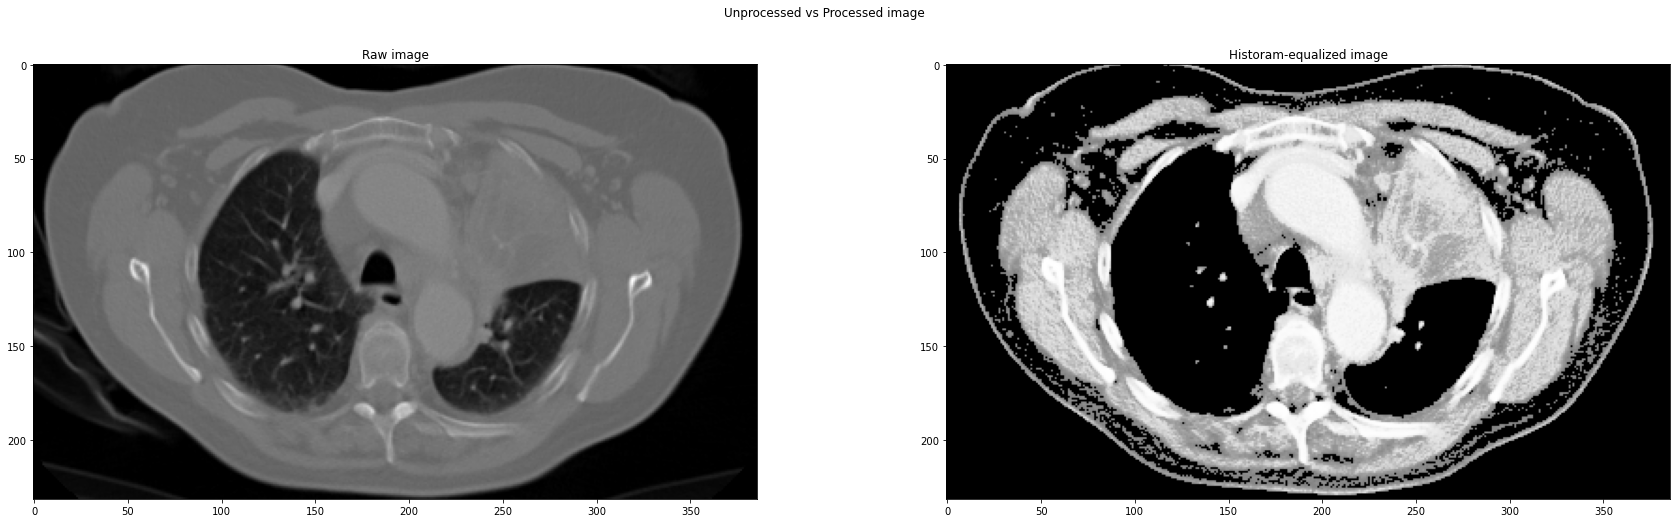

In [ ]:
plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(os.path.join(DIR, CATS[0], 'adenocarcinoma10.png')))
plt.title('Raw image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(os.path.join(DEST_DIR,'cancerous', 'adenocarcinoma10.png')))
plt.title('Historam-equalized image')
plt.suptitle('Unprocessed vs Processed image')
plt.show()

<div style='font-size:100%;'>
    <a id='preprocess'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Splitting the processed images</center>
    </h1>
</div>

In [4]:
FINAL_DIR = './processedData'

splitfolders.ratio(DEST_DIR, output=FINAL_DIR, seed=69420, ratio=(.7, 0.1,0.2)) 

Copying files: 1000 files [00:00, 4894.96 files/s]


In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2,                  
                                                                rotation_range=5,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                fill_mode='nearest'
                                                                )

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

test_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [69]:
train_dataset  = train_datagen.flow_from_directory(directory = './finalData/train',
                                                   target_size = (224,224),
                                                   class_mode = 'binary',
                                                   batch_size = 32)

Found 699 images belonging to 2 classes.


In [70]:
valid_dataset = valid_datagen.flow_from_directory(directory = './finalData/val',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 99 images belonging to 2 classes.


In [71]:
test_dataset = test_datagen.flow_from_directory(directory = './finalData/test',
                                                  target_size = (224,224),
                                                  class_mode = 'binary',
                                                  batch_size = 32)

Found 202 images belonging to 2 classes.


<div style='font-size:100%;'>
    <a id='preprocess'></a>
    <h1 style='color: gray; font-weight: bold; font-family: Cascadia code;'>
        <center>Neural nets</center>
    </h1>
</div>

In [134]:
def F1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
      tf.keras.metrics.Precision(name='Precision'),
      tf.keras.metrics.Recall(name='Recall'),  
      tf.keras.metrics.AUC(name='AUC'),
      F1,
]

In [141]:
CNN = tf.keras.Sequential()
CNN.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
CNN.add(tf.keras.layers.Conv2D(filters=36, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
CNN.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Flatten())
CNN.add(tf.keras.layers.Dense(units=64, activation='relu'))
CNN.add(tf.keras.layers.Dropout(rate=0.25))
CNN.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

CNN.summary()

CNN.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 conv2d_17 (Conv2D)          (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 36)     0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 52, 52, 128)     

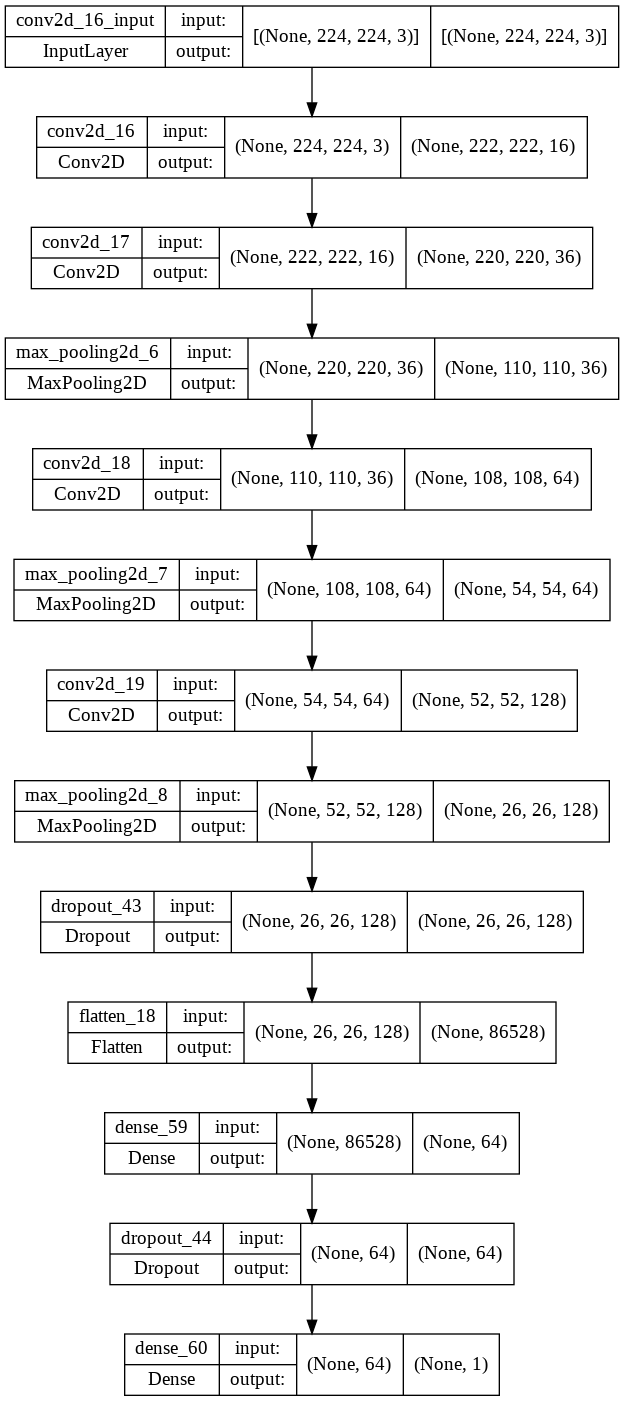

In [142]:
tf.keras.utils.plot_model(CNN, to_file='CNN.png', show_shapes=True,show_layer_names=True)
Image(filename='CNN.png')

In [146]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('CNN.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

CNN.fit(train_dataset,validation_data=valid_dataset, epochs = 36,verbose = 1, callbacks=[lrd,mcp,es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.3090 - Accuracy: 0.8655 - Precision: 0.7545 - Recall: 0.5533 - AUC: 0.8997 - F1: 0.5952

22/22 [==============================] - 10s 437ms/step - loss: 0.3090 - Accuracy: 0.8655 - Precision: 0.7545 - Recall: 0.5533 - AUC: 0.8997 - F1: 0.5952 - val_loss: 0.1943 - val_Accuracy: 0.9394 - val_Precision: 0.8571 - val_Recall: 0.8571 - val_AUC: 0.9933 - val_F1: 0.8854 - lr: 5.0000e-04
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.2983 - Accuracy: 0.8784 - Precision: 0.8095 - Recall: 0.5667 - AUC: 0.9101 - F1: 0.6201

22/22 [==============================] - 10s 435ms/step - loss: 0.2983 - Accuracy: 0.8784 - Precision: 0.8095 - Recall: 0.5667 - AUC: 0.9101 - F1: 0.6201 - val_loss: 0.4557 - val_Accuracy: 0.7374 - val_Precision: 0.4468 - val_Recall: 1.0000 - val_AUC: 0.9765 - val_F1: 0.4784 - lr: 5.0000e-04
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.2543 - Accuracy: 0.8941 - Precision: 0.8276 - Recall: 0.6400 - AUC: 0.9389 - F1: 0.7049

22/22 [==============================] - 9s 395ms/step - loss: 0.2543 - Accuracy: 0.8941 - Precision: 0.8276 - Recall: 0.6400 - AUC: 0.9389 - F1: 0.7049 - val_loss: 0.1291 - val_Accuracy: 0.9596 - val_Precision: 0.8696 - val_Recall: 0.9524 - val_AUC: 0.9963 - val_F1: 0.6936 - lr: 5.0000e-04
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.2550 - Accuracy: 0.8956 - Precision: 0.8130 - Recall: 0.6667 - AUC: 0.9376 - F1: 0.6866

22/22 [==============================] - 9s 408ms/step - loss: 0.2550 - Accuracy: 0.8956 - Precision: 0.8130 - Recall: 0.6667 - AUC: 0.9376 - F1: 0.6866 - val_loss: 0.2237 - val_Accuracy: 0.8990 - val_Precision: 0.6774 - val_Recall: 1.0000 - val_AUC: 0.9927 - val_F1: 0.7931 - lr: 5.0000e-04
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.2509 - Accuracy: 0.8870 - Precision: 0.8447 - Recall: 0.5800 - AUC: 0.9424 - F1: 0.6662

22/22 [==============================] - 10s 462ms/step - loss: 0.2509 - Accuracy: 0.8870 - Precision: 0.8447 - Recall: 0.5800 - AUC: 0.9424 - F1: 0.6662 - val_loss: 0.2911 - val_Accuracy: 0.8384 - val_Precision: 0.5676 - val_Recall: 1.0000 - val_AUC: 0.9924 - val_F1: 0.5312 - lr: 5.0000e-04
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.2425 - Accuracy: 0.8870 - Precision: 0.7934 - Recall: 0.6400 - AUC: 0.9483 - F1: 0.6928
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


22/22 [==============================] - 9s 427ms/step - loss: 0.2425 - Accuracy: 0.8870 - Precision: 0.7934 - Recall: 0.6400 - AUC: 0.9483 - F1: 0.6928 - val_loss: 0.2067 - val_Accuracy: 0.9091 - val_Precision: 0.7000 - val_Recall: 1.0000 - val_AUC: 0.9957 - val_F1: 0.8149 - lr: 5.0000e-04
Epoch 6: early stopping


In [147]:
CNN_scores = CNN.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 1s 75ms/step - loss: 0.1705 - Accuracy: 0.9455 - Precision: 0.8000 - Recall: 1.0000 - AUC: 0.9926 - F1: 0.8686


In [151]:
VGG16_base = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")

for layer in VGG16_base.layers:
    layer.trainable = False

VGG16=tf.keras.Sequential()
VGG16.add(VGG16_base)
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Flatten())
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dropout(0.5))
VGG16.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
VGG16.add(tf.keras.layers.BatchNormalization())
VGG16.add(tf.keras.layers.Activation('relu'))
VGG16.add(tf.keras.layers.Dense(1,activation='sigmoid'))

VGG16.summary()

VGG16.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_48 (Dropout)        (None, 7, 7, 512)         0         
                                                                 
 flatten_20 (Flatten)        (None, 25088)             0         
                                                                 
 batch_normalization_64 (Bat  (None, 25088)            100352    
 chNormalization)                                                
                                                                 
 dense_65 (Dense)            (None, 32)                802848    
                                                                 
 batch_normalization_65 (Bat  (None, 32)               128       
 chNormalization)                                    

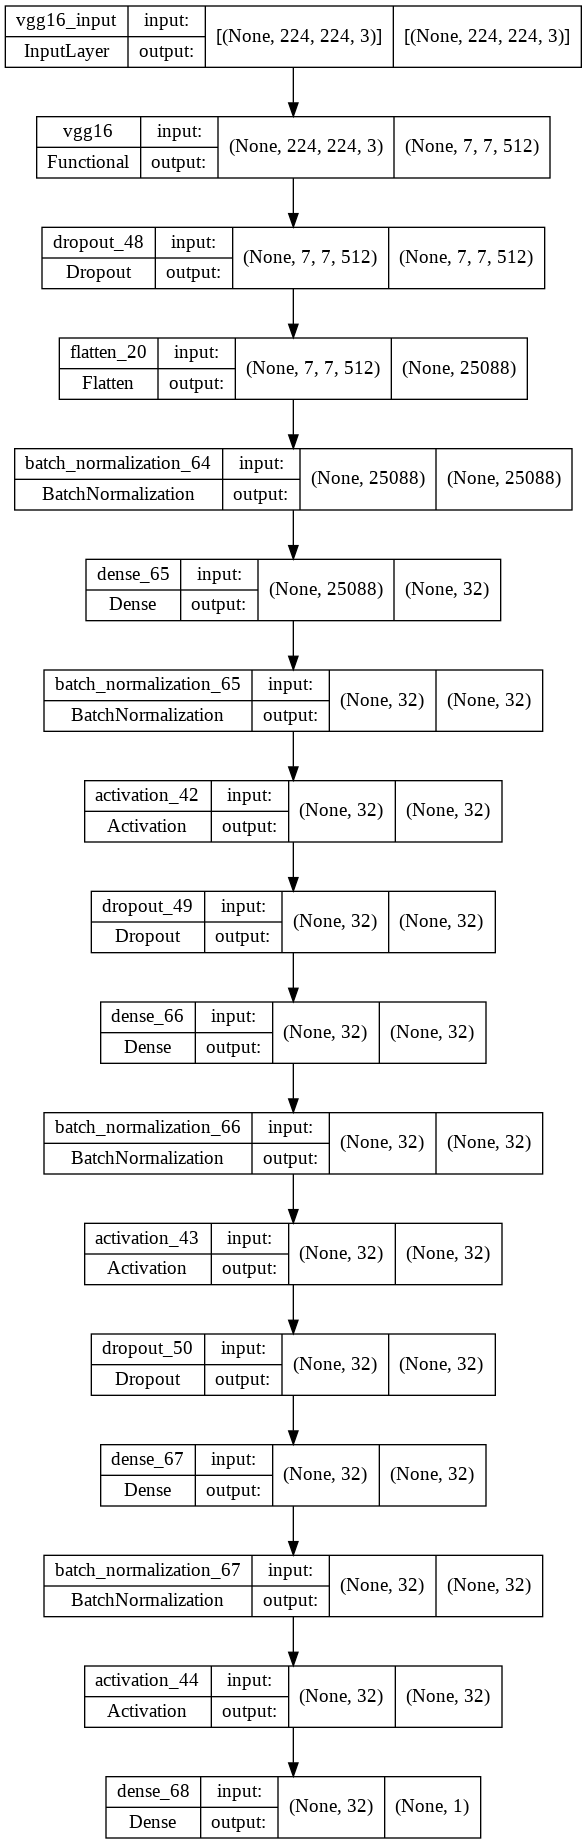

In [152]:
tf.keras.utils.plot_model(VGG16, to_file='VGG16.png', show_shapes=True,show_layer_names=True)
Image(filename='VGG16.png')

In [153]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('VGG16.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

VGG16.fit(train_dataset,validation_data=valid_dataset, epochs = 36,verbose = 1, callbacks=[lrd,mcp,es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.5733 - Accuracy: 0.7725 - Precision: 0.4718 - Recall: 0.4742 - AUC: 0.7582 - F1: 0.3293

22/22 [==============================] - 12s 457ms/step - loss: 0.5733 - Accuracy: 0.7725 - Precision: 0.4718 - Recall: 0.4742 - AUC: 0.7582 - F1: 0.3293 - val_loss: 0.5781 - val_Accuracy: 0.7879 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_AUC: 0.9020 - val_F1: 0.0000e+00 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.4827 - Accuracy: 0.7768 - Precision: 0.4667 - Recall: 0.2800 - AUC: 0.7204 - F1: 0.3319

22/22 [==============================] - 9s 428ms/step - loss: 0.4827 - Accuracy: 0.7768 - Precision: 0.4667 - Recall: 0.2800 - AUC: 0.7204 - F1: 0.3319 - val_loss: 0.3988 - val_Accuracy: 0.7980 - val_Precision: 1.0000 - val_Recall: 0.0476 - val_AUC: 0.9319 - val_F1: 0.0500 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.4529 - Accuracy: 0.8269 - Precision: 0.6933 - Recall: 0.3467 - AUC: 0.7520 - F1: 0.4717

22/22 [==============================] - 10s 429ms/step - loss: 0.4529 - Accuracy: 0.8269 - Precision: 0.6933 - Recall: 0.3467 - AUC: 0.7520 - F1: 0.4717 - val_loss: 0.3223 - val_Accuracy: 0.8485 - val_Precision: 1.0000 - val_Recall: 0.2857 - val_AUC: 0.9802 - val_F1: 0.2637 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.4117 - Accuracy: 0.8026 - Precision: 0.5682 - Recall: 0.3333 - AUC: 0.8239 - F1: 0.4116

22/22 [==============================] - 10s 429ms/step - loss: 0.4117 - Accuracy: 0.8026 - Precision: 0.5682 - Recall: 0.3333 - AUC: 0.8239 - F1: 0.4116 - val_loss: 0.2733 - val_Accuracy: 0.8485 - val_Precision: 1.0000 - val_Recall: 0.2857 - val_AUC: 0.9982 - val_F1: 0.3687 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.3752 - Accuracy: 0.8498 - Precision: 0.7228 - Recall: 0.4867 - AUC: 0.8537 - F1: 0.5811

22/22 [==============================] - 10s 431ms/step - loss: 0.3752 - Accuracy: 0.8498 - Precision: 0.7228 - Recall: 0.4867 - AUC: 0.8537 - F1: 0.5811 - val_loss: 0.2436 - val_Accuracy: 0.8586 - val_Precision: 1.0000 - val_Recall: 0.3333 - val_AUC: 0.9905 - val_F1: 0.5861 - lr: 0.0010
Epoch 6/36
22/22 [==============================] - ETA: 0s - loss: 0.3498 - Accuracy: 0.8455 - Precision: 0.6981 - Recall: 0.4933 - AUC: 0.8838 - F1: 0.5903

22/22 [==============================] - 10s 430ms/step - loss: 0.3498 - Accuracy: 0.8455 - Precision: 0.6981 - Recall: 0.4933 - AUC: 0.8838 - F1: 0.5903 - val_loss: 0.2102 - val_Accuracy: 0.9293 - val_Precision: 1.0000 - val_Recall: 0.6667 - val_AUC: 0.9875 - val_F1: 0.5777 - lr: 0.0010
Epoch 7/36
22/22 [==============================] - ETA: 0s - loss: 0.3386 - Accuracy: 0.8555 - Precision: 0.7290 - Recall: 0.5200 - AUC: 0.8821 - F1: 0.5839

22/22 [==============================] - 10s 431ms/step - loss: 0.3386 - Accuracy: 0.8555 - Precision: 0.7290 - Recall: 0.5200 - AUC: 0.8821 - F1: 0.5839 - val_loss: 0.1837 - val_Accuracy: 0.9293 - val_Precision: 1.0000 - val_Recall: 0.6667 - val_AUC: 0.9908 - val_F1: 0.5958 - lr: 0.0010
Epoch 8/36
22/22 [==============================] - ETA: 0s - loss: 0.2951 - Accuracy: 0.8798 - Precision: 0.7946 - Recall: 0.5933 - AUC: 0.9200 - F1: 0.6814

22/22 [==============================] - 10s 432ms/step - loss: 0.2951 - Accuracy: 0.8798 - Precision: 0.7946 - Recall: 0.5933 - AUC: 0.9200 - F1: 0.6814 - val_loss: 0.1605 - val_Accuracy: 0.9798 - val_Precision: 1.0000 - val_Recall: 0.9048 - val_AUC: 0.9863 - val_F1: 0.9556 - lr: 0.0010
Epoch 9/36
22/22 [==============================] - ETA: 0s - loss: 0.2773 - Accuracy: 0.8798 - Precision: 0.7619 - Recall: 0.6400 - AUC: 0.9289 - F1: 0.6856

22/22 [==============================] - 11s 506ms/step - loss: 0.2773 - Accuracy: 0.8798 - Precision: 0.7619 - Recall: 0.6400 - AUC: 0.9289 - F1: 0.6856 - val_loss: 0.1409 - val_Accuracy: 0.9596 - val_Precision: 1.0000 - val_Recall: 0.8095 - val_AUC: 0.9823 - val_F1: 0.9000 - lr: 0.0010
Epoch 10/36
22/22 [==============================] - ETA: 0s - loss: 0.2573 - Accuracy: 0.8856 - Precision: 0.7917 - Recall: 0.6333 - AUC: 0.9411 - F1: 0.7079

22/22 [==============================] - 10s 459ms/step - loss: 0.2573 - Accuracy: 0.8856 - Precision: 0.7917 - Recall: 0.6333 - AUC: 0.9411 - F1: 0.7079 - val_loss: 0.1411 - val_Accuracy: 0.9596 - val_Precision: 1.0000 - val_Recall: 0.8095 - val_AUC: 0.9890 - val_F1: 0.8426 - lr: 0.0010
Epoch 11/36
22/22 [==============================] - ETA: 0s - loss: 0.2258 - Accuracy: 0.9056 - Precision: 0.8443 - Recall: 0.6867 - AUC: 0.9612 - F1: 0.7561

22/22 [==============================] - 12s 535ms/step - loss: 0.2258 - Accuracy: 0.9056 - Precision: 0.8443 - Recall: 0.6867 - AUC: 0.9612 - F1: 0.7561 - val_loss: 0.1209 - val_Accuracy: 0.9596 - val_Precision: 1.0000 - val_Recall: 0.8095 - val_AUC: 0.9902 - val_F1: 0.6583 - lr: 0.0010
Epoch 12/36
22/22 [==============================] - ETA: 0s - loss: 0.2140 - Accuracy: 0.9084 - Precision: 0.8413 - Recall: 0.7067 - AUC: 0.9671 - F1: 0.7630

22/22 [==============================] - 11s 496ms/step - loss: 0.2140 - Accuracy: 0.9084 - Precision: 0.8413 - Recall: 0.7067 - AUC: 0.9671 - F1: 0.7630 - val_loss: 0.1038 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9878 - val_F1: 0.9808 - lr: 0.0010
Epoch 13/36
22/22 [==============================] - ETA: 0s - loss: 0.2179 - Accuracy: 0.9256 - Precision: 0.8451 - Recall: 0.8000 - AUC: 0.9577 - F1: 0.8073

22/22 [==============================] - 10s 445ms/step - loss: 0.2179 - Accuracy: 0.9256 - Precision: 0.8451 - Recall: 0.8000 - AUC: 0.9577 - F1: 0.8073 - val_loss: 0.1005 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9872 - val_F1: 0.7333 - lr: 0.0010
Epoch 14/36
22/22 [==============================] - ETA: 0s - loss: 0.2392 - Accuracy: 0.9156 - Precision: 0.8182 - Recall: 0.7800 - AUC: 0.9478 - F1: 0.7868

22/22 [==============================] - 10s 434ms/step - loss: 0.2392 - Accuracy: 0.9156 - Precision: 0.8182 - Recall: 0.7800 - AUC: 0.9478 - F1: 0.7868 - val_loss: 0.1029 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9841 - val_F1: 0.7500 - lr: 0.0010
Epoch 15/36
22/22 [==============================] - ETA: 0s - loss: 0.1970 - Accuracy: 0.9227 - Precision: 0.8429 - Recall: 0.7867 - AUC: 0.9646 - F1: 0.7933

22/22 [==============================] - 10s 434ms/step - loss: 0.1970 - Accuracy: 0.9227 - Precision: 0.8429 - Recall: 0.7867 - AUC: 0.9646 - F1: 0.7933 - val_loss: 0.1096 - val_Accuracy: 0.9697 - val_Precision: 1.0000 - val_Recall: 0.8571 - val_AUC: 0.9799 - val_F1: 0.9363 - lr: 0.0010
Epoch 16/36
22/22 [==============================] - ETA: 0s - loss: 0.1785 - Accuracy: 0.9328 - Precision: 0.8652 - Recall: 0.8133 - AUC: 0.9705 - F1: 0.8346
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 10s 433ms/step - loss: 0.1785 - Accuracy: 0.9328 - Precision: 0.8652 - Recall: 0.8133 - AUC: 0.9705 - F1: 0.8346 - val_loss: 0.1132 - val_Accuracy: 0.9697 - val_Precision: 1.0000 - val_Recall: 0.8571 - val_AUC: 0.9838 - val_F1: 0.7106 - lr: 0.0010
Epoch 16: early stopping


In [154]:
VGG16_scores = VGG16.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 1s 138ms/step - loss: 0.0565 - Accuracy: 0.9950 - Precision: 0.9778 - Recall: 1.0000 - AUC: 0.9991 - F1: 0.9916


## MobileNet

In [155]:
MOBILENET_base =  tf.keras.applications.MobileNet(input_shape=(224,224,3), include_top= False)

for layer in MOBILENET_base.layers:
    layer.trainable = False

MOBILENET=tf.keras.Sequential()
MOBILENET.add(MOBILENET_base)
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Flatten())
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dropout(0.5))
MOBILENET.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
MOBILENET.add(tf.keras.layers.BatchNormalization())
MOBILENET.add(tf.keras.layers.Activation('relu'))
MOBILENET.add(tf.keras.layers.Dense(1,activation='sigmoid'))

MOBILENET.summary()

MOBILENET.compile(optimizer='rmsprop',
              loss=tf.keras.losses.binary_crossentropy, metrics=METRICS)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 dropout_51 (Dropout)        (None, 7, 7, 1024)        0         
                                                                 
 flatten_21 (Flatten)        (None, 50176)             0         
                                                                 
 batch_normalization_68 (Bat  (None, 50176)            200704    
 chNormalization)                                                
                                                                 
 dense_69 (Dense)            (None, 32)                1605664   
                                                                 
 batch_normalization_69 (Bat  (None, 32)             

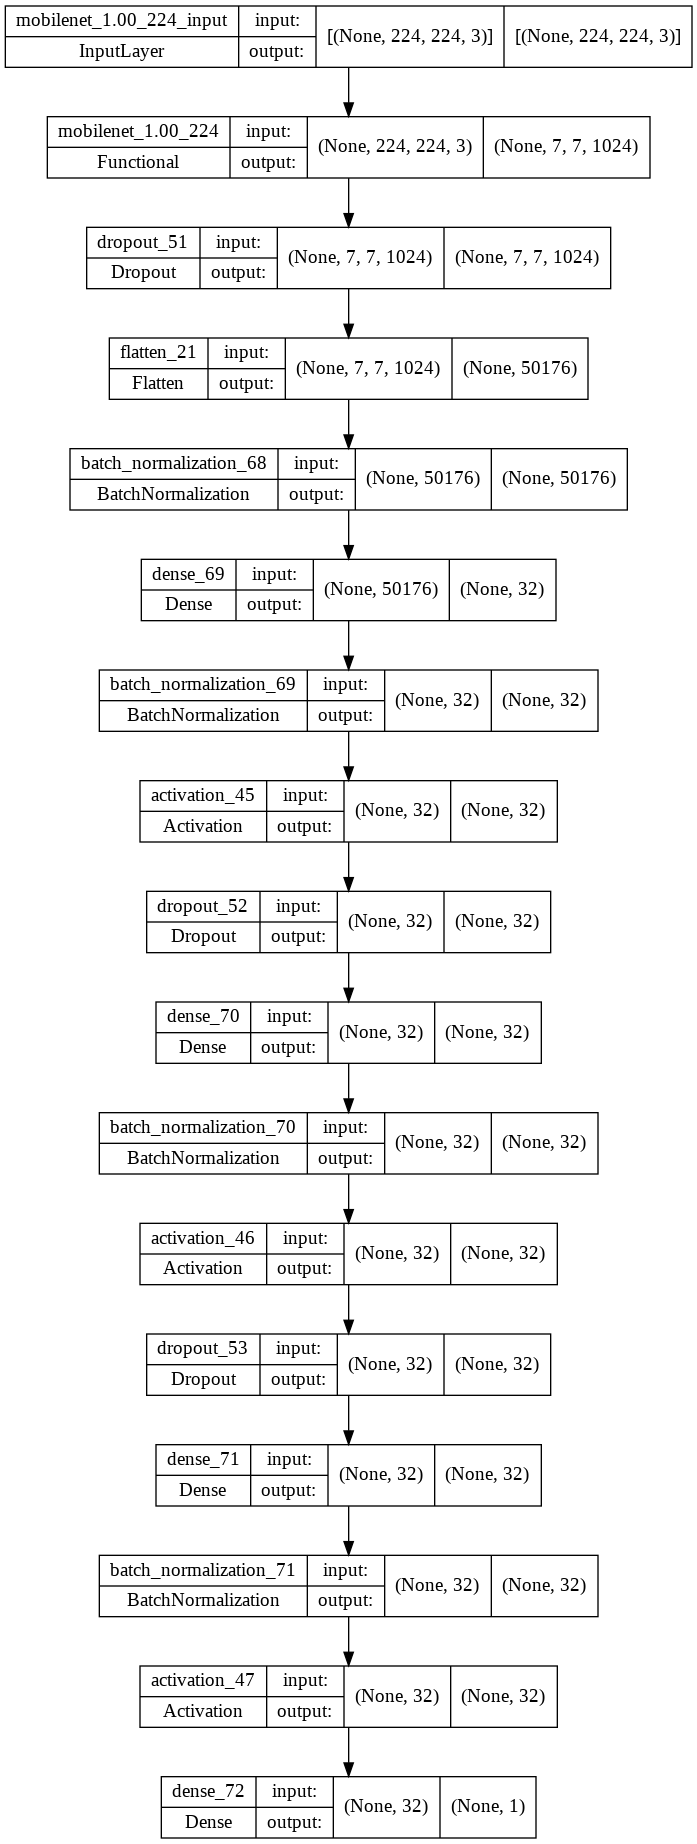

In [156]:
tf.keras.utils.plot_model(MOBILENET, to_file='MOBILENET.png', show_shapes=True,show_layer_names=True)
Image(filename='MOBILENET.png')

In [157]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1,factor = 0.50, min_lr = 1e-7)

mcp = tf.keras.callbacks.ModelCheckpoint('MOBILENET.h5', save_best_only=True, mode='auto', monitor='val_accuracy')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=3)

MOBILENET.fit(train_dataset,validation_data=valid_dataset,epochs = 36,verbose = 1, callbacks=[lrd, mcp, es], shuffle=True)

Epoch 1/36
22/22 [==============================] - ETA: 0s - loss: 0.5877 - Accuracy: 0.7758 - Precision: 0.4844 - Recall: 0.6392 - AUC: 0.8135 - F1: 0.4467

22/22 [==============================] - 12s 422ms/step - loss: 0.5877 - Accuracy: 0.7758 - Precision: 0.4844 - Recall: 0.6392 - AUC: 0.8135 - F1: 0.4467 - val_loss: 0.1684 - val_Accuracy: 0.9495 - val_Precision: 1.0000 - val_Recall: 0.7619 - val_AUC: 0.9588 - val_F1: 0.8974 - lr: 0.0010
Epoch 2/36
22/22 [==============================] - ETA: 0s - loss: 0.4145 - Accuracy: 0.8612 - Precision: 0.6906 - Recall: 0.6400 - AUC: 0.8640 - F1: 0.6468

22/22 [==============================] - 9s 419ms/step - loss: 0.4145 - Accuracy: 0.8612 - Precision: 0.6906 - Recall: 0.6400 - AUC: 0.8640 - F1: 0.6468 - val_loss: 0.1372 - val_Accuracy: 0.9899 - val_Precision: 1.0000 - val_Recall: 0.9524 - val_AUC: 0.9557 - val_F1: 0.9833 - lr: 0.0010
Epoch 3/36
22/22 [==============================] - ETA: 0s - loss: 0.3696 - Accuracy: 0.8727 - Precision: 0.7563 - Recall: 0.6000 - AUC: 0.8773 - F1: 0.6554

22/22 [==============================] - 8s 377ms/step - loss: 0.3696 - Accuracy: 0.8727 - Precision: 0.7563 - Recall: 0.6000 - AUC: 0.8773 - F1: 0.6554 - val_loss: 0.2139 - val_Accuracy: 0.9697 - val_Precision: 0.9091 - val_Recall: 0.9524 - val_AUC: 0.9554 - val_F1: 0.9356 - lr: 0.0010
Epoch 4/36
22/22 [==============================] - ETA: 0s - loss: 0.3228 - Accuracy: 0.8898 - Precision: 0.8120 - Recall: 0.6333 - AUC: 0.9043 - F1: 0.6917

22/22 [==============================] - 8s 381ms/step - loss: 0.3228 - Accuracy: 0.8898 - Precision: 0.8120 - Recall: 0.6333 - AUC: 0.9043 - F1: 0.6917 - val_loss: 0.2108 - val_Accuracy: 0.9697 - val_Precision: 0.9091 - val_Recall: 0.9524 - val_AUC: 0.9603 - val_F1: 0.6968 - lr: 0.0010
Epoch 5/36
22/22 [==============================] - ETA: 0s - loss: 0.2453 - Accuracy: 0.9242 - Precision: 0.8647 - Recall: 0.7667 - AUC: 0.9609 - F1: 0.8092
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


22/22 [==============================] - 8s 382ms/step - loss: 0.2453 - Accuracy: 0.9242 - Precision: 0.8647 - Recall: 0.7667 - AUC: 0.9609 - F1: 0.8092 - val_loss: 0.1855 - val_Accuracy: 0.9596 - val_Precision: 0.8696 - val_Recall: 0.9524 - val_AUC: 0.9628 - val_F1: 0.9473 - lr: 0.0010
Epoch 5: early stopping


In [159]:
MOBILENET_scores = MOBILENET.evaluate(test_dataset, verbose=1)

7/7 [==============================] - 1s 75ms/step - loss: 0.1725 - Accuracy: 0.9851 - Precision: 0.9362 - Recall: 1.0000 - AUC: 0.9996 - F1: 0.8353


In [160]:
[CNN_scores, VGG16_scores, MOBILENET_scores]

[[0.17050494253635406,
  0.9455445408821106,
  0.800000011920929,
  1.0,
  0.9925919771194458,
  0.8685786128044128],
 [0.05645787715911865,
  0.9950494766235352,
  0.9777777791023254,
  1.0,
  0.9991369247436523,
  0.9915966391563416],
 [0.17251288890838623,
  0.9851484894752502,
  0.936170220375061,
  1.0,
  0.9995684623718262,
  0.835338294506073]]